### Segmentation of gliomas in pre-operative MRI scans.

Each pixel on image must be labeled:

Pixel is part of a tumor area (1 or 2 or 3) -> can be one of multiple classes / sub-regions
Anything else -> pixel is not on a tumor region (0)
The sub-regions of tumor considered for evaluation are: 
1) the "enhancing tumor" (ET), 
2) the "tumor core" (TC), and 
3) the "whole tumor" (WT) 
The provided segmentation labels have values of 1 for NCR & NET, 2 for ED, 4 for ET, and 0 for everything else.

In [1]:
import os
# import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps   


# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
# !pip install git+https://github.com/miykael/gif_your_nifti # nifti to gif 
# import gif_your_nifti.core as gif2nif


# ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

2024-03-22 01:02:51.307771: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# !pip install SimpleITK tqdm matplotlib nibabel albumentations pydicom nibabel torch torchvision opencv-python scikit-image nilearn

In [5]:
# pip install opencv-python

In [4]:
# import cv2

In [3]:

SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', 
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

In [4]:
import os
import random

# Directory containing your data
data_directory = '/data'

# Exclude the specific path you want to skip
excluded_path = '/data/UCSF-PDGM-0541_nifti'
excluded_dirname = os.path.basename(excluded_path)
if excluded_path in data_directory:
    data_directory = data_directory.replace(excluded_path, '')

# List all files in the directory
all_files = os.listdir(data_directory)


# Shuffle the list of files
random.shuffle(all_files)

# Define the number of files for training and validation
num_train_files = 400

# Split the shuffled list into training and validation sets
train_files = all_files[:num_train_files]
val_files = all_files[num_train_files:]

# Define the paths for training and validation datasets
TRAIN_DATASET_PATH = [os.path.join(data_directory, file) for file in train_files]
VAL_DATASET_PATH = [os.path.join(data_directory, file) for file in val_files]

# Print the first few file paths for verification
print("Training Dataset Paths:")
print(TRAIN_DATASET_PATH[:5])  # Print the first 5 paths
print("\nValidation Dataset Paths:")
print(VAL_DATASET_PATH[:5])    # Print the first 5 paths


Training Dataset Paths:
['/data/UCSF-PDGM-0355_nifti', '/data/UCSF-PDGM-0498_nifti', '/data/UCSF-PDGM-0435_nifti', '/data/UCSF-PDGM-0076_nifti', '/data/UCSF-PDGM-0375_nifti']

Validation Dataset Paths:
['/data/UCSF-PDGM-0239_nifti', '/data/UCSF-PDGM-0419_nifti', '/data/UCSF-PDGM-0067_nifti', '/data/UCSF-PDGM-0528_nifti', '/data/UCSF-PDGM-0142_nifti']


In [5]:
# print("All Files:")
# print(all_files)


In [57]:
ID = "UCSF-PDGM-0498_nifti"

# List files within the directory associated with the ID
if ID in train_files:
    id_directory = os.path.join(data_directory, ID)
    files = os.listdir(id_directory)

    # Load NIfTI files for the specified ID
    if len(files) == 23:
        _t1 = nib.load(os.path.join(id_directory, files[11])).get_fdata()
        _flair = nib.load(os.path.join(id_directory, files[15])).get_fdata()
        _t1ce = nib.load(os.path.join(id_directory, files[20])).get_fdata()
        _t2 = nib.load(os.path.join(id_directory, files[19])).get_fdata()
        _mask = nib.load(os.path.join(id_directory, files[9])).get_fdata()

        # You can now work with these loaded data arrays
    else:
        print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
else:
    print(f"ID '{ID}' not found in the training set.") 


### Image data descriptions
All BraTS multimodal scans are available as NIfTI files (.nii.gz) -> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.
T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.
T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.
FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper. The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

Text(0.5, 1.0, 'Mask')

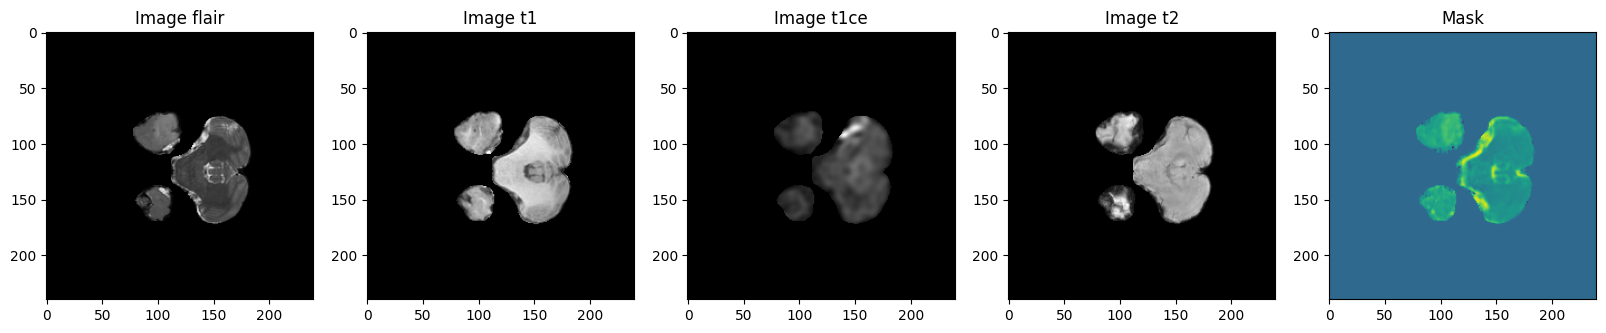

In [58]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize=(20, 10))
slice_w = 25
ax1.imshow(_flair[:,:, _flair.shape[2]//2 - slice_w], cmap='gray')
ax1.set_title('Image flair')
ax2.imshow(_t1[:,:, _t1.shape[2]//2 - slice_w], cmap='gray')
ax2.set_title('Image t1')
ax3.imshow(_t1ce[:,:, _t1ce.shape[2]//2 - slice_w], cmap='gray')
ax3.set_title('Image t1ce')
ax4.imshow(_t2[:,:, _t2.shape[2]//2 - slice_w], cmap='gray')
ax4.set_title('Image t2')
ax5.imshow(_mask[:,:, _mask.shape[2]//2 - slice_w])
ax5.set_title('Mask')

### Show whole nifti data -> print each slice from 3d data

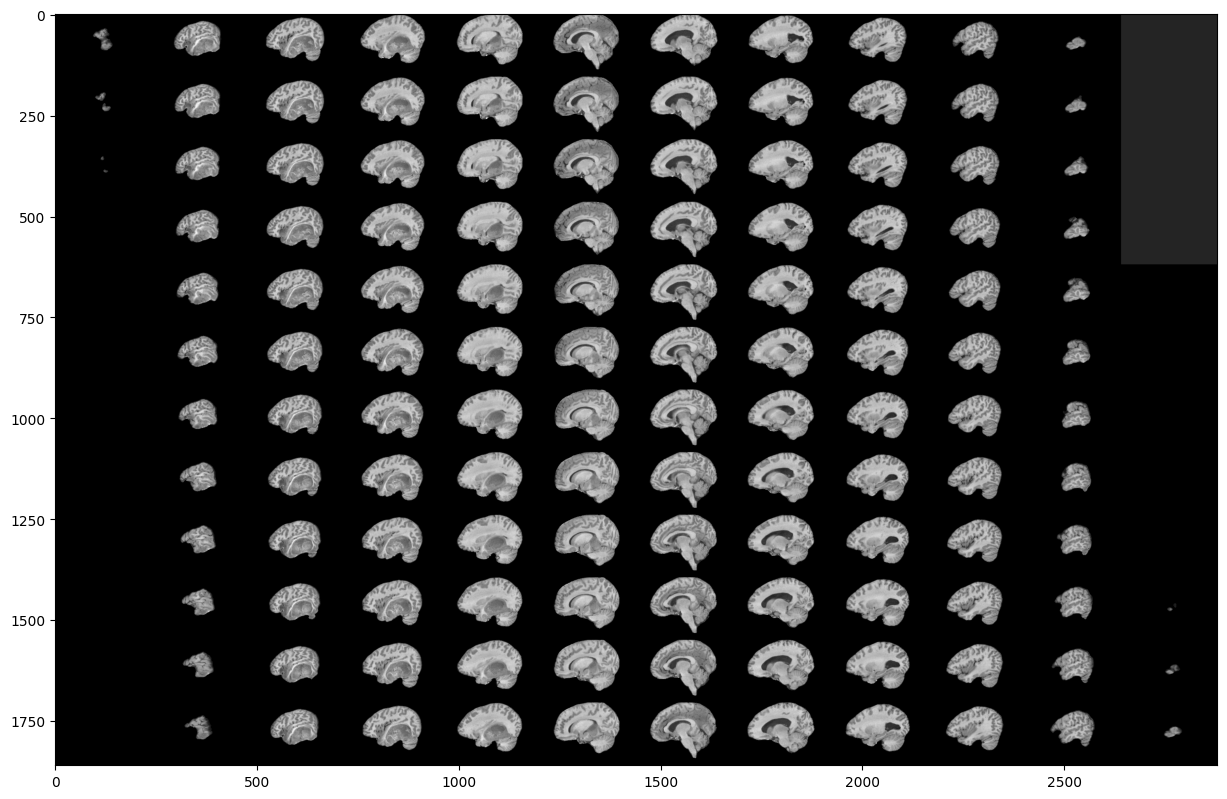

In [59]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

### Show whole nifti data -> print each slice from 3d data

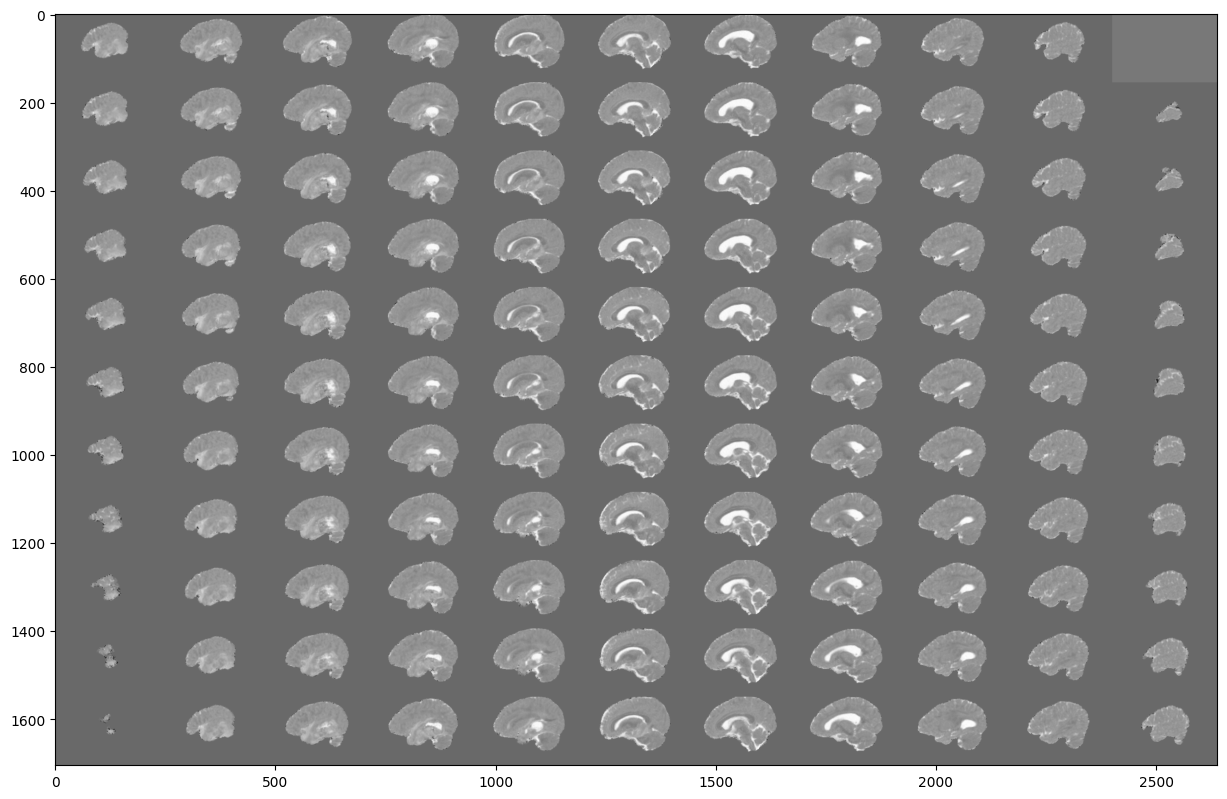

In [60]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

### Show segments of tumor using different effects

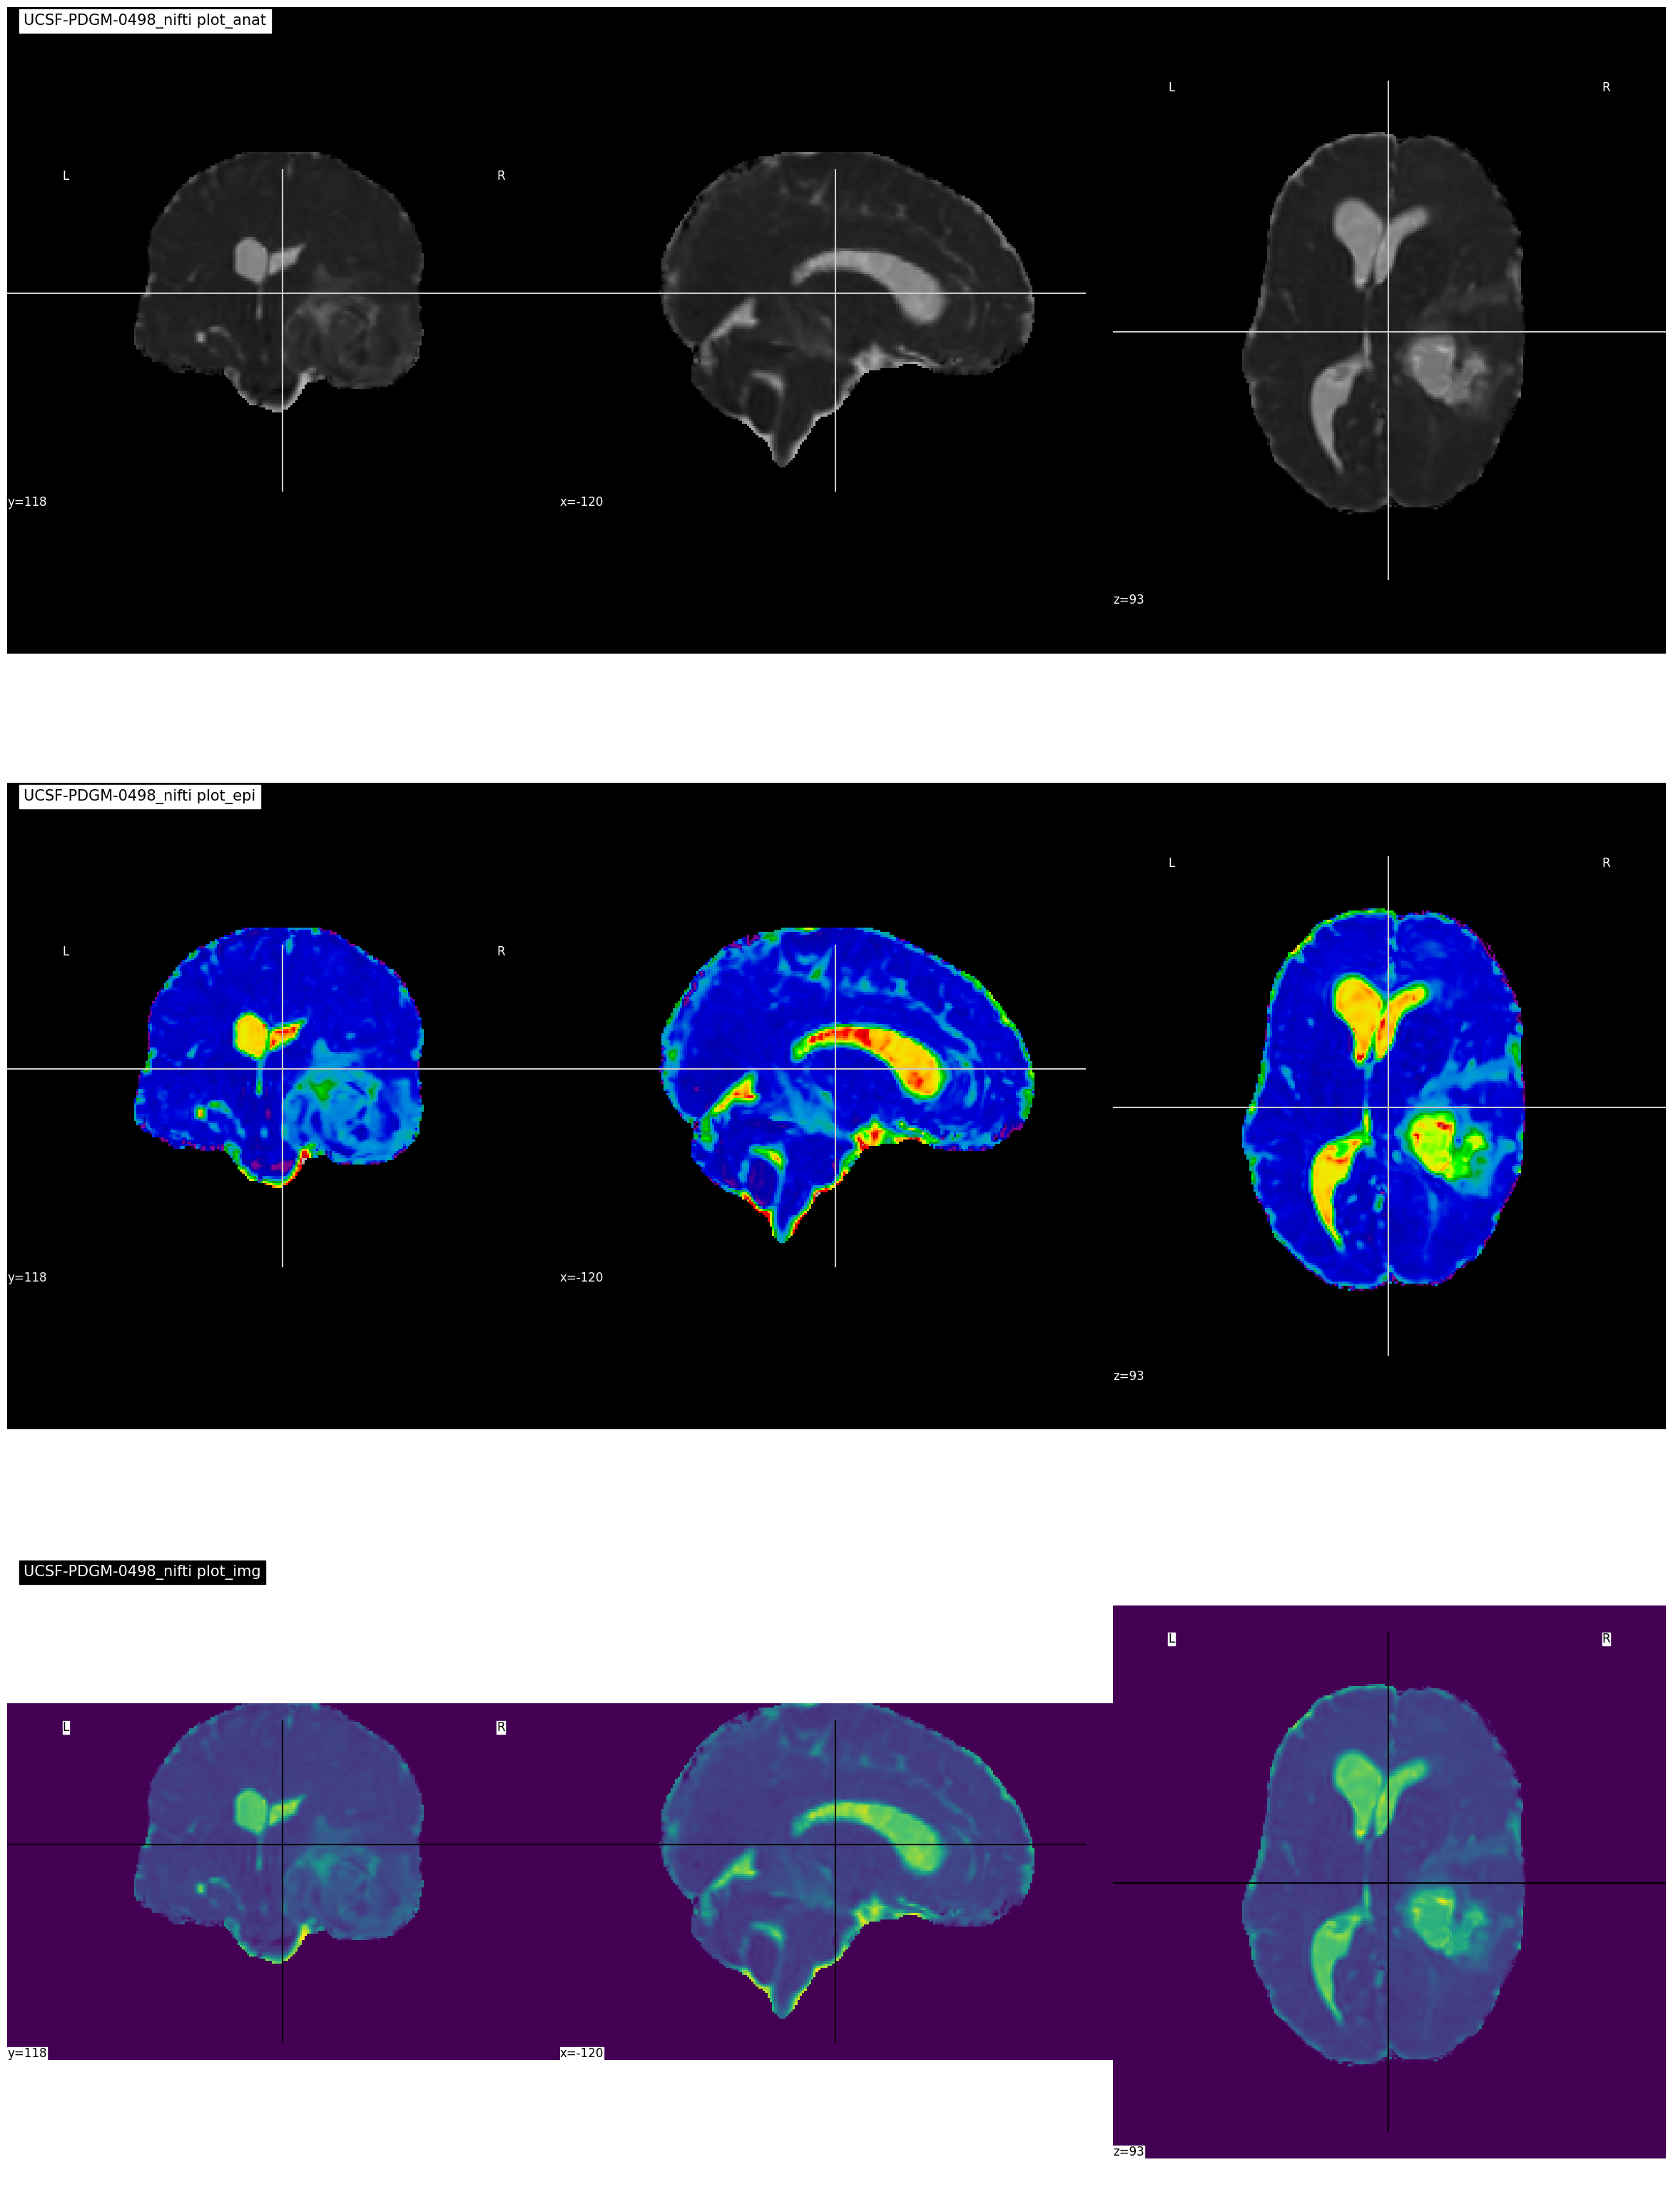

In [61]:
#Show the flair images in a different format
# taken from: taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
import nibabel as nib
import os
import nilearn.plotting as nlplt
import matplotlib.pyplot as plt

# Example ID
ID = "UCSF-PDGM-0498_nifti"

# List files within the directory associated with the ID
if ID in train_files:
    id_directory = os.path.join(data_directory, ID)
    files = os.listdir(id_directory)

    # Load NIfTI files for the specified ID
    if len(files) == 23:
        niimg = nib.load(os.path.join(id_directory, files[7]))

        fig, axes = plt.subplots(nrows=3, figsize=(30, 40))

        # Plot anatomical images
        # Visualize the brain's structural anatomy.
        # Anatomical images typically refer to high-resolution structural MRI
        nlplt.plot_anat(niimg,
                        title='UCSF-PDGM-0498_nifti plot_anat',
                        axes=axes[0])

        # Plot EPI (Echo Planar Imaging) images
        # Used in tasks like fMRI resting-state analysis and activation mapping.
        nlplt.plot_epi(niimg,
                       title='UCSF-PDGM-0498_nifti plot_epi',
                       axes=axes[1])

        nlplt.plot_img(niimg,
                       title='UCSF-PDGM-0498_nifti plot_img',
                       axes=axes[2])

        plt.show()
    else:
        print(f"Expected 23 files for ID '{ID}', but found {len(files)} files.")
else:
    print(f"ID '{ID}' not found in the training set.")

### Loss function¶
Dice coefficient , which is essentially a measure of overlap between two samples. This measure ranges from 0 to 1 where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

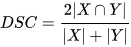





In [6]:
# Taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [7]:
IMG_SIZE=128

In [8]:
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Dropout, concatenate
from keras.models import Model

def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))


model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

2024-03-22 01:05:16.222800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31136 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:06:00.0, compute capability: 7.0
2024-03-22 01:05:16.225398: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31136 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:07:00.0, compute capability: 7.0
2024-03-22 01:05:16.226998: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 31136 MB memory:  -> device: 2, name: Tesla V100-SXM2-32GB, pci bus id: 0000:0a:00.0, compute capability: 7.0
2024-03-22 01:05:16.228554: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1638] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 31136 MB memory:  -> device: 3, name: Tesla V100-SXM2-32GB, pci bus id

In [66]:
# TRAIN_DATASET_PATH

In [9]:
train_and_val_directories = TRAIN_DATASET_PATH + VAL_DATASET_PATH
train_and_val_directories

# Function to extract study IDs from directory paths
def pathListIntoIds(dirList):
    x = [dirList[i][dirList[i].rfind('/')+1:] for i in range(len(dirList))]
    return x

# Extract the IDs
train_and_test_ids = pathListIntoIds(train_and_val_directories)

# Split the  IDs into training, testing, and validation sets
train_test_ids, val_ids = train_test_split(train_and_test_ids, test_size=0.2)
train_ids, test_ids = train_test_split(train_test_ids, test_size=0.15)


In [10]:
print(test_ids)


['UCSF-PDGM-0372_nifti', 'UCSF-PDGM-0082_nifti', 'UCSF-PDGM-0464_nifti', 'UCSF-PDGM-0507_nifti', 'UCSF-PDGM-0326_nifti', 'UCSF-PDGM-0371_nifti', 'UCSF-PDGM-0443_nifti', 'UCSF-PDGM-0410_nifti', 'UCSF-PDGM-0107_nifti', 'UCSF-PDGM-0196_nifti', 'UCSF-PDGM-0262_nifti', 'UCSF-PDGM-0252_nifti', 'UCSF-PDGM-0273_nifti', 'UCSF-PDGM-0535_nifti', 'UCSF-PDGM-0370_nifti', 'UCSF-PDGM-0415_nifti', 'UCSF-PDGM-0392_nifti', 'UCSF-PDGM-0119_nifti', 'UCSF-PDGM-0010_nifti', 'UCSF-PDGM-0387_nifti', 'UCSF-PDGM-0528_nifti', 'UCSF-PDGM-0246_nifti', 'UCSF-PDGM-0466_nifti', 'UCSF-PDGM-0135_nifti', 'UCSF-PDGM-0031_nifti', 'UCSF-PDGM-0399_nifti', 'UCSF-PDGM-0237_nifti', 'UCSF-PDGM-0424_nifti', 'UCSF-PDGM-0382_nifti', 'UCSF-PDGM-0506_nifti', 'UCSF-PDGM-0170_nifti', 'UCSF-PDGM-0089_nifti', 'UCSF-PDGM-0494_nifti', 'UCSF-PDGM-0522_nifti', 'UCSF-PDGM-0356_nifti', 'UCSF-PDGM-0523_nifti', 'UCSF-PDGM-0013_nifti', 'UCSF-PDGM-0076_nifti', 'UCSF-PDGM-0411_nifti', 'UCSF-PDGM-0105_nifti', 'UCSF-PDGM-0207_nifti', 'UCSF-PDGM-0510

In [11]:
import re  

def extractIDWithoutNifti(ID):
    # Remove "_nifti" and additional characters like "_FUXXXd"
    cleaned_id = re.sub(r'_nifti|_FU\d+d', '', ID)
    return cleaned_id

# Extract IDs without "_nifti" and additional characters based on the original IDs
train_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in train_ids]
val_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in val_ids]
test_ids_without_nifti = [extractIDWithoutNifti(ID) for ID in test_ids]

# Verify if the IDs have the correct format
for study_id in train_ids_without_nifti + val_ids_without_nifti + test_ids_without_nifti:
    if not re.match(r'^[A-Z0-9-]+$', study_id):
        print(f"Invalid study ID: {study_id}")



In [12]:
test_ids_without_nifti

['UCSF-PDGM-0372',
 'UCSF-PDGM-0082',
 'UCSF-PDGM-0464',
 'UCSF-PDGM-0507',
 'UCSF-PDGM-0326',
 'UCSF-PDGM-0371',
 'UCSF-PDGM-0443',
 'UCSF-PDGM-0410',
 'UCSF-PDGM-0107',
 'UCSF-PDGM-0196',
 'UCSF-PDGM-0262',
 'UCSF-PDGM-0252',
 'UCSF-PDGM-0273',
 'UCSF-PDGM-0535',
 'UCSF-PDGM-0370',
 'UCSF-PDGM-0415',
 'UCSF-PDGM-0392',
 'UCSF-PDGM-0119',
 'UCSF-PDGM-0010',
 'UCSF-PDGM-0387',
 'UCSF-PDGM-0528',
 'UCSF-PDGM-0246',
 'UCSF-PDGM-0466',
 'UCSF-PDGM-0135',
 'UCSF-PDGM-0031',
 'UCSF-PDGM-0399',
 'UCSF-PDGM-0237',
 'UCSF-PDGM-0424',
 'UCSF-PDGM-0382',
 'UCSF-PDGM-0506',
 'UCSF-PDGM-0170',
 'UCSF-PDGM-0089',
 'UCSF-PDGM-0494',
 'UCSF-PDGM-0522',
 'UCSF-PDGM-0356',
 'UCSF-PDGM-0523',
 'UCSF-PDGM-0013',
 'UCSF-PDGM-0076',
 'UCSF-PDGM-0411',
 'UCSF-PDGM-0105',
 'UCSF-PDGM-0207',
 'UCSF-PDGM-0510',
 'UCSF-PDGM-0215',
 'UCSF-PDGM-0097',
 'UCSF-PDGM-0386',
 'UCSF-PDGM-0362',
 'UCSF-PDGM-0405',
 'UCSF-PDGM-0511',
 'UCSF-PDGM-0504',
 'UCSF-PDGM-0324',
 'UCSF-PDGM-0011',
 'UCSF-PDGM-0321',
 'UCSF-PDGM-

### Load data
Loading all data into memory is not a good idea since the data are too big to fit in. So we will create dataGenerators - load data on the fly as explained: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

### Override Keras sequence DataGenerator class

In [13]:
from skimage.transform import resize

# Taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_directory, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=2, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data_directory = data_directory  
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

            # adapted for the dataset
    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))

        # Generate data
        for c, i in enumerate(Batch_ids):
            # Extract study ID without '_nifti'
            nifti_without_id = extractIDWithoutNifti(i)


            # Use the NIfTI ID
            case_path = os.path.join(self.data_directory, nifti_without_id+"_nifti")  

            # Update the path with NIfTI ID
            data_path = os.path.join(case_path, f'{nifti_without_id}_FLAIR.nii')  
            flair = nib.load(data_path).get_fdata()

            # Update the path with NIfTI ID
            data_path = os.path.join(case_path, f'{nifti_without_id}_T1c.nii')  
            ce = nib.load(data_path).get_fdata()

            # Update the path with NIfTI ID
            data_path = os.path.join(case_path, f'{nifti_without_id}_tumor_segmentation.nii')  
            seg = nib.load(data_path).get_fdata()

            for j in range(VOLUME_SLICES):

                print("Shape before resizing - FLAIR:", flair.shape)
                print("Shape before resizing - CE:", ce.shape)
                
                # Resize the flair and ce images
                X[j + VOLUME_SLICES * c, :, :, 0] = resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                X[j + VOLUME_SLICES * c, :, :, 1] = resize(ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                print("Shape after resizing - FLAIR:", X[j + VOLUME_SLICES * c, :, :, 0].shape)
                print("Shape after resizing - CE:", X[j + VOLUME_SLICES * c, :, :, 1].shape)

                # Assign the segmentation mask directly
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Generate masks
        y[y == 4] = 3
        mask = tf.one_hot(y, 4)
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        return X / np.max(X), Y



        


training_generator = DataGenerator(data_directory, train_ids)



valid_generator = DataGenerator(data_directory, val_ids)
test_generator = DataGenerator(data_directory, test_ids)


In [14]:
# Remove "UCSF-PDGM-0541_nifti" from all lists
train_test_ids = [id for id in train_test_ids if id != "UCSF-PDGM-0541_nifti"]
val_ids = [id for id in val_ids if id != "UCSF-PDGM-0541_nifti"]
train_ids = [id for id in train_ids if id != "UCSF-PDGM-0541_nifti"]
test_ids = [id for id in test_ids if id != "UCSF-PDGM-0541_nifti"]

is_in_train_test_ids = "UCSF-PDGM-0541_nifti" in train_test_ids
is_in_val_ids = "UCSF-PDGM-0541_nifti" in val_ids
is_in_train_ids = "UCSF-PDGM-0541_nifti" in train_ids
is_in_test_ids = "UCSF-PDGM-0541_nifti" in test_ids

print(is_in_train_test_ids)
print(is_in_val_ids)
print(is_in_train_ids)
print(is_in_test_ids)

False
False
False
False


In [15]:
print(test_ids)

['UCSF-PDGM-0372_nifti', 'UCSF-PDGM-0082_nifti', 'UCSF-PDGM-0464_nifti', 'UCSF-PDGM-0507_nifti', 'UCSF-PDGM-0326_nifti', 'UCSF-PDGM-0371_nifti', 'UCSF-PDGM-0443_nifti', 'UCSF-PDGM-0410_nifti', 'UCSF-PDGM-0107_nifti', 'UCSF-PDGM-0196_nifti', 'UCSF-PDGM-0262_nifti', 'UCSF-PDGM-0252_nifti', 'UCSF-PDGM-0273_nifti', 'UCSF-PDGM-0535_nifti', 'UCSF-PDGM-0370_nifti', 'UCSF-PDGM-0415_nifti', 'UCSF-PDGM-0392_nifti', 'UCSF-PDGM-0119_nifti', 'UCSF-PDGM-0010_nifti', 'UCSF-PDGM-0387_nifti', 'UCSF-PDGM-0528_nifti', 'UCSF-PDGM-0246_nifti', 'UCSF-PDGM-0466_nifti', 'UCSF-PDGM-0135_nifti', 'UCSF-PDGM-0031_nifti', 'UCSF-PDGM-0399_nifti', 'UCSF-PDGM-0237_nifti', 'UCSF-PDGM-0424_nifti', 'UCSF-PDGM-0382_nifti', 'UCSF-PDGM-0506_nifti', 'UCSF-PDGM-0170_nifti', 'UCSF-PDGM-0089_nifti', 'UCSF-PDGM-0494_nifti', 'UCSF-PDGM-0522_nifti', 'UCSF-PDGM-0356_nifti', 'UCSF-PDGM-0523_nifti', 'UCSF-PDGM-0013_nifti', 'UCSF-PDGM-0076_nifti', 'UCSF-PDGM-0411_nifti', 'UCSF-PDGM-0105_nifti', 'UCSF-PDGM-0207_nifti', 'UCSF-PDGM-0510

### Number of data used: for training / testing / validation

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


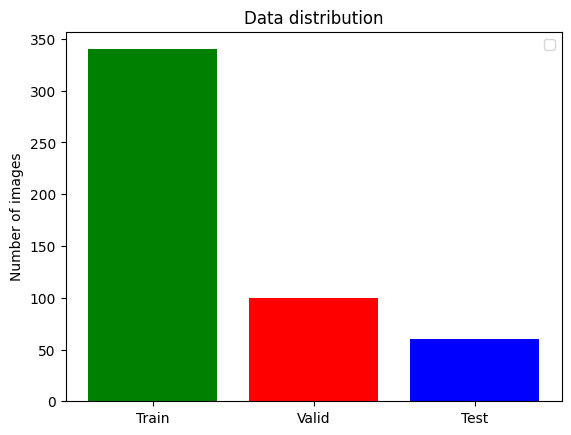

In [77]:
# show number of data for each dir 
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()

### Train model

My best model was trained with 76.4% accuracy on mean IOU and 62.3% on Dice loss

In [27]:
# Train model
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [

      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=0.000001, verbose=1),

        csv_logger
    ]

In [102]:
callbacks

In [35]:
# Train model, taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_ids),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )  
# for epoch in range(35):
#     for batch in training_generator:
#         X_batch, Y_batch = batch
#         predictions = model.predict(X_batch)  # Get predictions for the batch
#         # Add debug output to check for negative predictions
#         print("Batch Predictions: Min Value = {}, Max Value = {}".format(predictions.min(), predictions.max()))                    
model.save("2D_model.h5")

In [16]:
import os

def path_exists(path):
    """
    Check if a path exists.

    Args:
    path (str): The path to check.

    Returns:
    bool: True if the path exists, False if it does not.
    """
    return os.path.exists(path)



### Visualize the training process

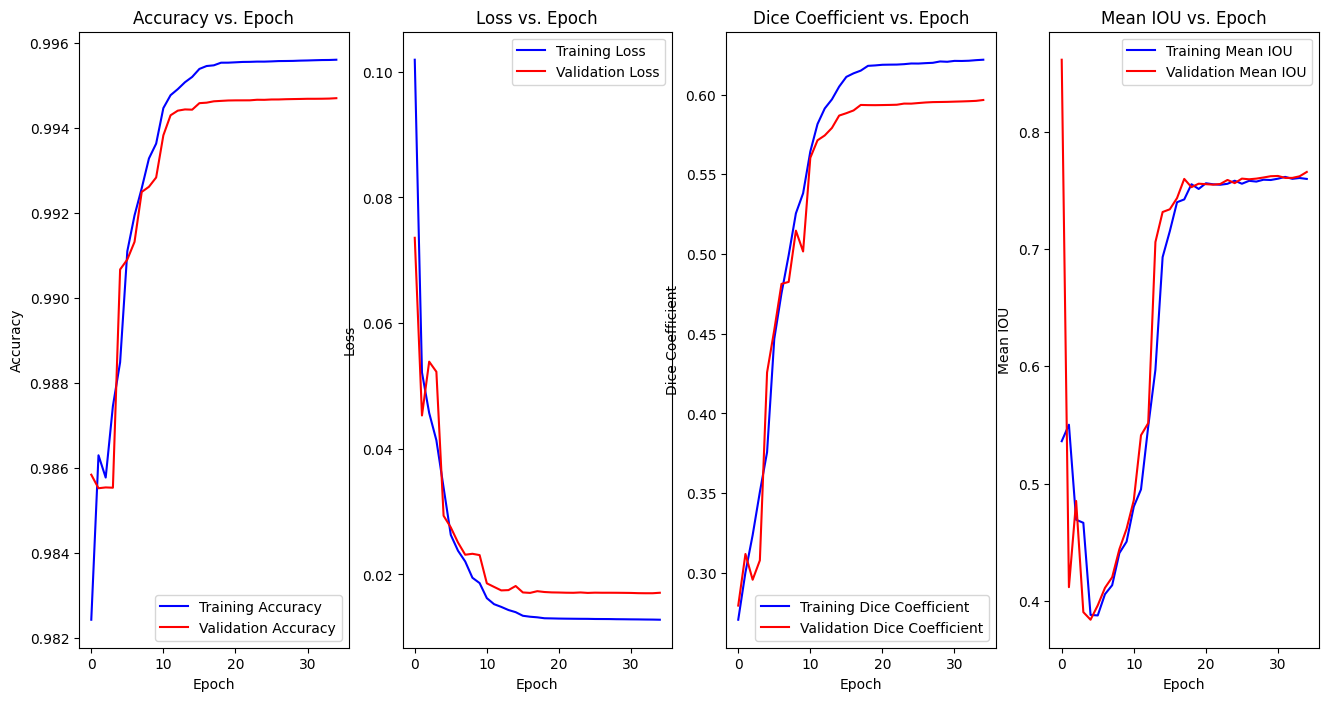

In [4]:
#taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
############ load trained model ################
model = keras.models.load_model('2D_model.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

history = pd.read_csv('training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

# hist=history.history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f, ax = plt.subplots(1, 4, figsize=(16, 8))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Accuracy vs. Epoch')

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss vs. Epoch')

ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coefficient')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coefficient')
ax[2].legend()
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Dice Coefficient')
ax[2].set_title('Dice Coefficient vs. Epoch')

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training Mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation Mean IOU')
ax[3].legend()
ax[3].set_xlabel('Epoch')
ax[3].set_ylabel('Mean IOU')
ax[3].set_title('Mean IOU vs. Epoch')


plt.show()

In [5]:
# mri type must one of 1) _FLAIR 2) _T1 3) _T1ce 4) t2 ------- or even 5) brain_tumor_segment
# returns volume of specified study at `path`
# taken from: taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
def imageLoader(path):
    image = nib.load(path).get_fdata()
    X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))
    for j in range(VOLUME_SLICES):
        X[j + VOLUME_SLICES * c, :, :, 0] = np.array(Image.fromarray(image[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        X[j + VOLUME_SLICES * c, :, :, 1] = np.array(Image.fromarray(ce[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

    return np.array(image)



# taken from: taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
from PIL import Image

def loadDataFromDir(path, list_of_files, mriType, n_images):
    scans = []
    masks = []
    for i in list_of_files[:n_images]:
        fullPath = glob.glob( i + '/*'+ mriType +'*')[0]
        currentScanVolume = imageLoader(fullPath)
        currentMaskVolume = imageLoader( glob.glob( i + '/*seg*')[0] )
        # for each slice in 3D volume, find also its mask
        for j in range(0, currentScanVolume.shape[2]):
            scan_img = np.array(Image.fromarray(currentScanVolume[:, :, j]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST), dtype='float32')
            mask_img = np.array(Image.fromarray(currentMaskVolume[:, :, j]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST), dtype='float32')
            scans.append(scan_img[..., np.newaxis])
            masks.append(mask_img[..., np.newaxis])
    return np.array(scans, dtype='float32'), np.array(masks, dtype='float32')

        


### Prediction examples

In [6]:
#Adapted from: taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
def predictByPath(case_path, case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, extractIDWithoutNifti(case)+"_FLAIR.nii")
    flair = nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, extractIDWithoutNifti(case)+"_T1c.nii")
    ce = nib.load(vol_path).get_fdata()

    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = np.array(Image.fromarray(flair[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))
        X[j, :, :, 1] = np.array(Image.fromarray(ce[:, :, j + VOLUME_START_AT]).resize((IMG_SIZE, IMG_SIZE), Image.NEAREST))

    # Perform the predictions on the resized images
    predictions = model.predict(X / np.max(X), verbose=1)
    
    return predictions


In [7]:
#Adapted from: taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
def showPredictsById(case, start_slice = 60):

    case_path = "/data/"+case
    gt_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_tumor_segmentation.nii"
    origImage_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_FLAIR.nii"

    gt = nib.load(gt_path).get_fdata()
    origImage = nib.load(origImage_path).get_fdata()
    p = predictByPath(case_path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]
    
    
    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50)) 

    for i in range(6):  # for each image, add brain background
        axarr[i].imshow(origImage[:, :, start_slice + VOLUME_START_AT], cmap="gray", interpolation='none')

    axarr[0].imshow(origImage[:, :, start_slice + VOLUME_START_AT], cmap="gray")
    axarr[0].title.set_text('Original image flair')
    curr_gt = gt[:, :, start_slice + VOLUME_START_AT]
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)  # ,alpha=0.3,cmap='Reds'
    axarr[1].title.set_text('Ground truth')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('all classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[4].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[5].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()

In [105]:
# test_ids

In [17]:
# show predictions, taken from: 
# showPredictsById(case=test_ids[0])
# showPredictsById(case=test_ids[1])
# showPredictsById(case=test_ids[2])
# showPredictsById(case=test_ids[3])
# showPredictsById(case=test_ids[4])
# showPredictsById(case=test_ids[5])
# showPredictsById(case=test_ids[6])

# mask = np.zeros((10,10))
# mask[3:-3, 3:-3] = 1 # white square in black background
# im = mask + np.random.randn(10,10) * 0.01 # random image
# masked = np.ma.masked_where(mask == 0, mask)

# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(im, 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(im, 'gray', interpolation='none')
# plt.imshow(masked, 'jet', interpolation='none', alpha=0.7)
# plt.show()

In [102]:
# print(test_ids[0])

In [103]:
# print(extractIDWithoutNifti(test_ids[0]))

In [104]:
# path = "/data/"+test_ids[0]+"/"+extractIDWithoutNifti(test_ids[0])+"_tumor_segmentation.nii"
# if path_exists(path):
#     print(f"The path '{path}' exists.")
# else:
#     print(f"The path '{path}' does not exist.")

### Evaluation

4/4 [==============================] - 0s 38ms/step


<Figure size 640x480 with 0 Axes>

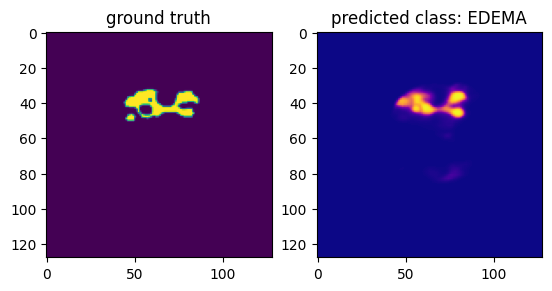

In [121]:
# adapted from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
from skimage.transform import resize

case = case=test_ids[1]
path = "/data/"+case
gt_path = "/data/"+case+"/"+extractIDWithoutNifti(case)+"_tumor_segmentation.nii"
gt = nib.load(gt_path).get_fdata()
p = predictByPath(path,case)

core = p[:,:,:,1]
edema = p[:,:,:,2]
enhancing = p[:,:,:,3]

i = 40  # slice at
eval_class = 2  # 0: 'NOT tumor', 1: 'ENHANCING', 2: 'CORE', 3: 'WHOLE'

gt[gt != eval_class] = 1  # use only one class for per class evaluation

resized_gt = resize(gt[:,:,i+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

plt.figure()
f, axarr = plt.subplots(1, 2)
axarr[0].imshow(resized_gt, cmap="viridis")
axarr[0].title.set_text('ground truth')
axarr[1].imshow(p[i,:,:,eval_class], cmap="plasma")
axarr[1].title.set_text(f'predicted class: {SEGMENT_CLASSES[eval_class]}')
plt.show()


In [113]:
# taken from: https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)



Evaluate on test data


2023-11-03 20:20:34.002787: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


60/60 [==============================] - 25s 371ms/step - loss: 0.0136 - accuracy: 0.9952 - mean_io_u_2: 0.7641 - dice_coef: 0.6246 - precision: 0.9953 - sensitivity: 0.9942 - specificity: 0.9984 - dice_coef_necrotic: 0.5220 - dice_coef_edema: 0.7503 - dice_coef_enhancing: 0.6514
test loss, test acc: [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]


Evaluate on test data
2023-11-03 20:20:34.002787: I tensorflow/core/common_runtime/executor.cc:1209] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
60/60 [==============================] - 25s 371ms/step - loss: 0.0136 - accuracy: 0.9952 - mean_io_u_2: 0.7641 - dice_coef: 0.6246 - precision: 0.9953 - sensitivity: 0.9942 - specificity: 0.9984 - dice_coef_necrotic: 0.5220 - dice_coef_edema: 0.7503 - dice_coef_enhancing: 0.6514
test loss, test acc: [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]

In [125]:
import pandas as pd

metrics = ['Loss', 'Accuracy', 'Mean IoU', 'Dice Coef', 'Precision', 'Sensitivity', 'Specificity', 'Dice Coef Necrotic', 'Dice Coef Edema', 'Dice Coef Enhancing']
results = [0.01363442000001669, 0.9952207803726196, 0.7640625238418579, 0.6246000528335571, 0.9952878355979919, 0.9942043423652649, 0.9984077215194702, 0.5219959020614624, 0.7503048777580261, 0.6514140367507935]

# Create a DataFrame
df = pd.DataFrame({'Metric': metrics, 'Result': results})

# # Highlight specific metrics
# styled_df = df.style.apply(lambda x: ['background: yellow' if x['Metric'] in ['Mean IoU', 'Dice Coef'] else 'background: white'], axis=1)

# # Display the styled table
# styled_df

df


,Metric,Result
0,Loss,0.013634
1,Accuracy,0.995221
2,Mean IoU,0.764063
3,Dice Coef,0.624600
4,Precision,0.995288
5,Sensitivity,0.994204
6,Specificity,0.998408
7,Dice Coef Necrotic,0.521996
8,Dice Coef Edema,0.750305
9,Dice Coef Enhancing,0.651414
